In [1]:
from astropy.io import fits
import numpy as np
import scipy.integrate as integrate

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def BlackBody(nu_t):
    spec=(15/np.pi**4.0)*np.float128(nu_t**3/(np.exp(np.float128(nu_t))-1))
    return spec;
    
def dBlackBodydT(nu_t):
    if nu_t < 0.001:
        dbdt = nu_t**2-nu_t**4/12.0
    elif nu_t > 15:
        dbdt = nu_t**4*np.exp(-nu_t)
    else:
        dbdt=nu_t**4 *np.exp(nu_t)/(np.exp(nu_t)-1)**2   
    
    return dbdt;

def planck_mean(nu_t,hud):
    kappa=get_kap(nu_t,hud)
    return kappa*BlackBody(nu_t)
    
def rossmean(nu_t,hud):
    return dBlackBodydT(nu_t)/(hud[3].data['scattering'][0]/(1.67e-24*hud[1].data['value'][names=='density'])+get_kap(nu_t,hud))


In [12]:
def get_kap(nu_t,hud):
    energy=hud[3].data['energy']
    
    if nu_t>max(energy):
        return hud[3].data['opacity '][-1]
    
    
    
    return np.interp(nu_t,hud[3].data['energy'],hud[3].data['opacity'])/(1.67e-24*hud[1].data['value'][names=='density'])
    

In [18]:
Tgrid=np.logspace(np.log10(5e3),np.log10(1e6),100)
rhogrid=np.logspace(-15,-7,20)/1.67e-24
kappa_p_fr=np.zeros((np.size(Tgrid),np.size(rhogrid)))
kappa_a_fr=np.zeros((np.size(Tgrid),np.size(rhogrid)))

In [19]:
for nT in range(np.size(Tgrid)):
    for nrho in range(np.size(rhogrid)):
        num=str(nT*len(rhogrid)+nrho)
        
        hud = fits.open('/Users/asecunda/Documents/thesis/radsims1/toyanfeiv2 (1)/work//ares/opakout'+str(num)+'.fits')
        names=hud[1].data['parameter']
        
        T=Tgrid[nT]
        rho=rhogrid[nrho]
        result=integrate.quad(rossmean, 100, np.inf, args=(hud))
        weight=integrate.quad(dBlackBodydT,100, np.inf)
        if result[0] and weight[0] > 0:
            kappa_a_fr[nT,nrho]=weight[0]/result[0]

        result=integrate.quad(planck_mean, 100, np.inf, args=(hud))[0]
        weight=integrate.quad(BlackBody,100, np.inf)[0]

        if result and weight > 0:
            kappa_p_fr[nT,nrho]=result/weight

Text(0, 0.5, '$\\kappa_{\\rm r}$ [cm$^2~$g$^{-1}$]')

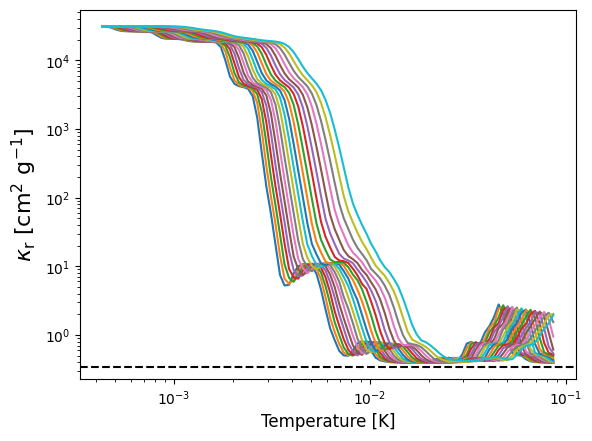

In [28]:
fig=plt.figure()
plt.plot(Tgrid/11604525.00617,kappa_a_fr)
#plt.ylim(0.1,1e3)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.axhline(0.34,color='black',linestyle='dashed')
plt.xlabel('Temperature [K]',fontsize=12)
plt.ylabel(r'$\kappa_{\rm r}$ [cm$^2~$g$^{-1}$]',fontsize=16)

Text(0, 0.5, '$\\kappa_{\\rm p}$ [cm$^2~$g$^{-1}$]')

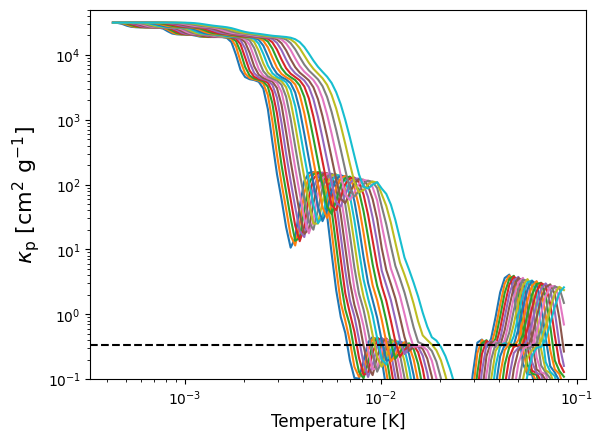

In [26]:
fig=plt.figure()
plt.plot(Tgrid/11604525.00617,kappa_p_fr)
plt.ylim(0.1,5e4)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.axhline(0.34,color='black',linestyle='dashed')
plt.xlabel('Temperature [K]',fontsize=12)
plt.ylabel(r'$\kappa_{\rm p}$ [cm$^2~$g$^{-1}$]',fontsize=16)